In [1]:
import gym
import timeit

import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm
import random
import json
from gym import spaces
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os
import math
import random
import tensorflow as tf
import argparse
import json
import datetime as dt

!pip install yfinance --upgrade --no-cache-dir
!pip install pandas-datareader
from pandas_datareader import data as pdr
import yfinance as yf




In [31]:
#initial_money = 10000
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    #metadata = {'render.modes': ['human']}

    def __init__(self, df,len_window):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.stock_price_history = np.around(df)
        self.len_obs = 5 
        self.len_window = len_window
        self.current_step = 0 
        # Actions of the format Buy , Sell , Hold.so #
       
        self.action_space = spaces.Discrete(3)
        self.batch_size = 32
        self.reward = 0 
        self.total_profit = 0 
        self.states_sell = []
        self.states_buy = []
        # The observation is the window size, like how many days of the data you are looking at
        self.observation_space = self.len_window
        self.initial_money = 100000
        self.act = 0 
        self.b = 0 

    def _next_observation(self,current_step):
        # Get the stock data points for the last n days and scale to between 0-1
        t = current_step
        n = self.len_window
        d = t - n + 1
        self.data = self.df
        block = self.data[d:t + 1] if d >= 0 else -d * [self.data[0]] + self.data[0:t + 1] # pad with t0
        res = []
        for i in range(n - 1):
            res.append(1 / (1 + math.exp(-(block[i + 1] - block[i]))))
            #the sigmoid function is used to scale it to 0-1.

        return np.array([res])
    def formatPrice(self,form):
        return ("-$" if form < 0 else "$") + "{0:.2f}".format(abs(form))
        #Just normal function to format the output
        
       
    def _take_action(self, action,current_step1):
        
        
        
       
        t = current_step1 - 1
        action_type = action # get the action from the get_action module in Agent
        if action == 1: # buy
            """price = self.formatPrice(self.data[t])
            #price = price.replace("$","")
            #price = float(price)
            
            #if(price <= self.initial_money):
                #self.initial_money = self.initial_money - price"""
            #the above commented code, is for when you wanna know the money left after every step, but we are just getting the profit.
            agent.inventory.append(self.data[t])
            self.states_buy.append(t)
            
            """print ("Buy: " + self.formatPrice(self.data[t]))
                #self.b=self.b+1
                #self.act = 0
            #else:
                print("Not enough money")"""

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)
            
            self.reward = max(self.data[t] - bought_price, 0)
            
            self.total_profit += self.data[t] - bought_price
            self.states_sell.append(t)
            #self.initial_money = self.initial_money + self.total_profit 
            #self.total_profit - bought_price
            #self.b = 0
            #self.act=0
            #print ("Sell: " + self.formatPrice(self.data[t]) + " | Profit: " + self.formatPrice(self.data[t] - bought_price))
            #print("Total Money is now " + str(self.initial_money+bought_price) )
            
        #if(self.b>10 or self.act>20):
            #self.reward+=-200
            
    def step(self, action,t2):
        # Execute one time step within the environment
        
        t2 = t2
        self._take_action(action,t2)#we are passing the current step  as argument in the take_action 
        l = len(self.df) - 1 
        
        
        done = True if t2 == l - 1 else False # it will change to flase when the length of the data and the current step are equal.

        obs = self._next_observation(t2)
        
        return obs, self.reward, done, {}

    def reset(self,current_step2):
        # Reset the state of the environment to an initial state
        self.total_profit = 0 
       # self.batch_size = 32
        self.states_sell = []
        self.states_buy = []
        
        return self._next_observation(current_step2)

    def render(self, mode='human', close=False):
        # Render the environment to the screen
    
        
        
        print(f'Profit: {self.total_profit}')
        fig = plt.figure(figsize = (15,5))
        plt.plot(self.df, color='red', lw=2.)
        plt.plot(self.df, '^', markersize=4, color='m', label = 'Buying signal', markevery = self.states_buy)
        plt.plot(self.df, 'v', markersize=4, color='k', label = 'Selling signal', markevery = self.states_sell)
        plt.title('Total gains: %f'%(self.total_profit))
        plt.legend()
        
        plt.show()

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque

      
class QNAgent:
    def __init__(self, env, discount_rate=0.97, learning_rate=0.01):
        self.action_size = env.action_space.n
        print('Action_size: ', self.action_size)
        self.state_size = int(env.observation_space)
        print('State size: ', self.state_size)
        self.memory = deque(maxlen=1000)
        self.discount_rate = discount_rate # gamma
        self.learning_rate = learning_rate #epsilon min
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.inventory = [] 
        
        #self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        
        self.model =  self._model # passing the model here , if we have some other model to be used , we can pass it here.

    def _model(self):

        self.model = Sequential()
        self.model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        self.model.add(Dense(units=32, activation="relu"))
        self.model.add(Dense(units=16, activation="relu"))
        self.model.add(Dense(self.action_size, activation="linear"))
        self.model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

        return self.model

    def get_action(self, state, use_random=True):
        
            
        if  np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        if(use_random):
            use_random = False
            return 1
        q_values = self.model().predict(state)
        return np.argmax(q_values[0])


    def train(self, batch_size ):
        minibatch = []
        length = len(self.memory)
        for i in range(l - batch_size + 1, l):
            minibatch.append(self.memory[i])

        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.discount_rate * np.max(self.model().predict(next_state)[0]) #q_values are upadated 

            target_f = self.model.predict(state) #the target function are updated
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.learning_rate:
            self.epsilon *= self.epsilon_decay 






[*********************100%***********************]  1 of 1 completed
Action_size:  3
State size:  10
Episode 0/100
--------------------------------
Profit: 13521.959716796875


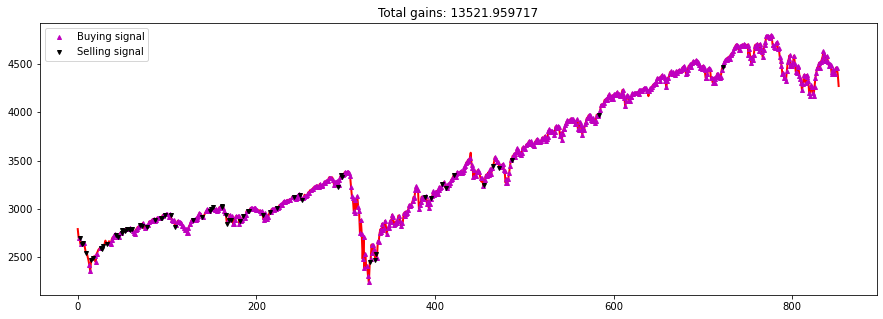

--------------------------------
Episode 1/100
--------------------------------
Profit: 2976.610107421875


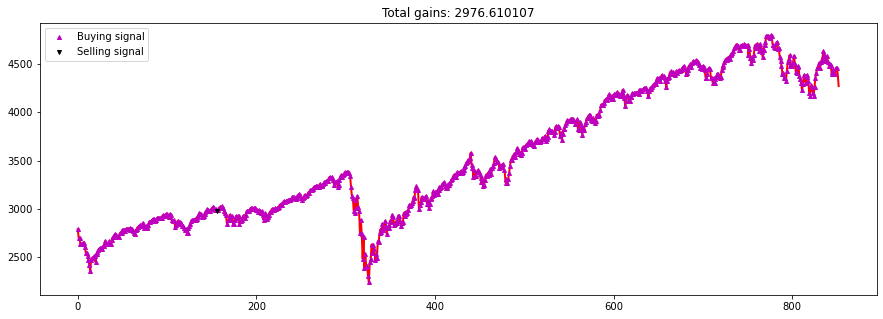

--------------------------------
Episode 2/100
--------------------------------
Profit: 3078.27001953125


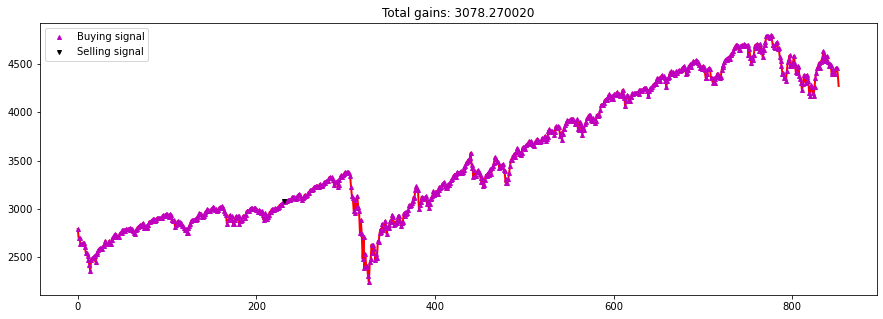

--------------------------------
Episode 3/100
--------------------------------
Profit: 3714.239990234375


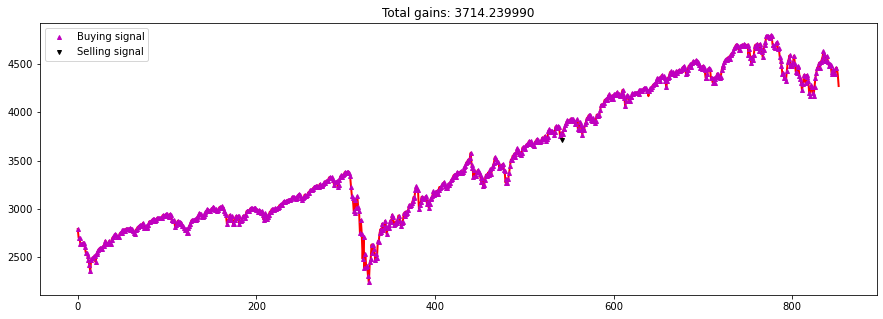

--------------------------------
Episode 4/100
--------------------------------
Profit: 7549.449951171875


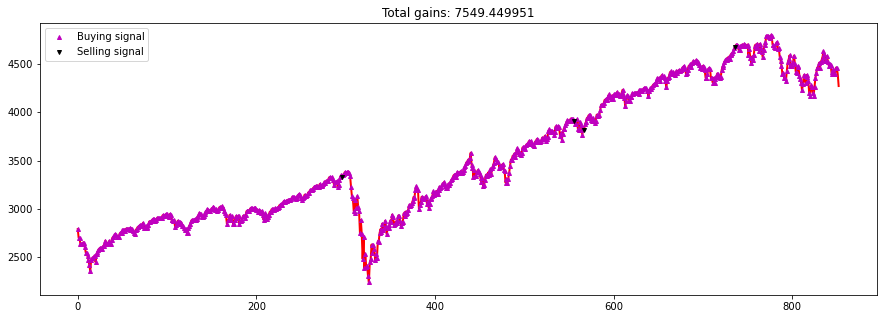

--------------------------------
Episode 5/100
--------------------------------
Profit: 6590.469482421875


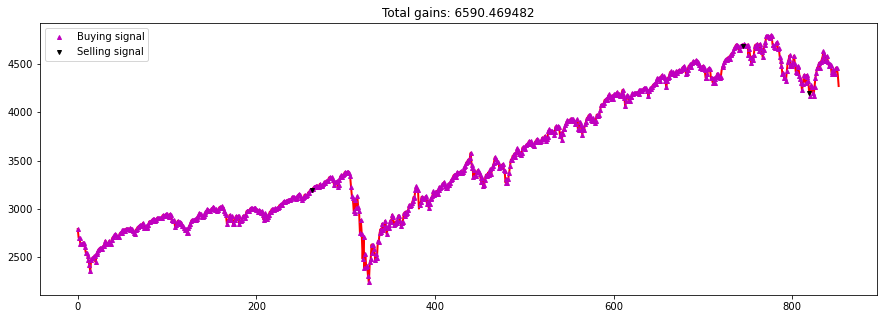

--------------------------------
Episode 6/100
--------------------------------
Profit: 7917.939453125


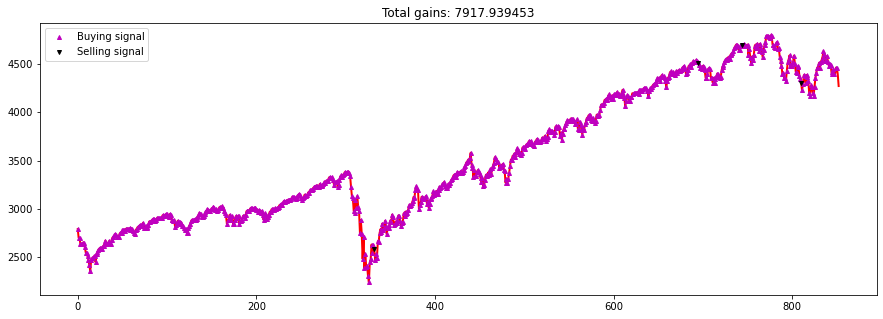

--------------------------------
Episode 7/100
--------------------------------
Profit: 3113.489990234375


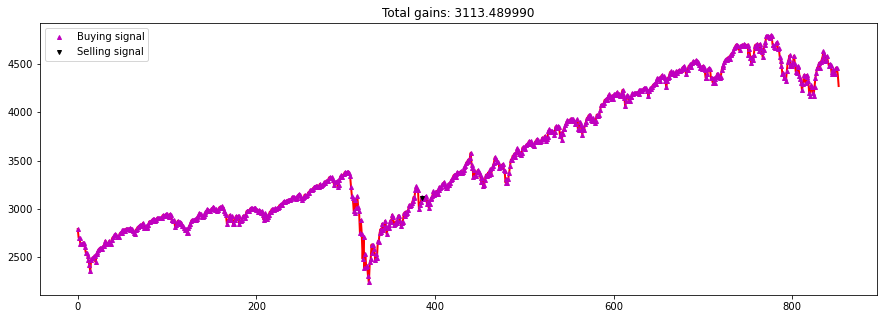

--------------------------------
Episode 8/100
--------------------------------
Profit: 0


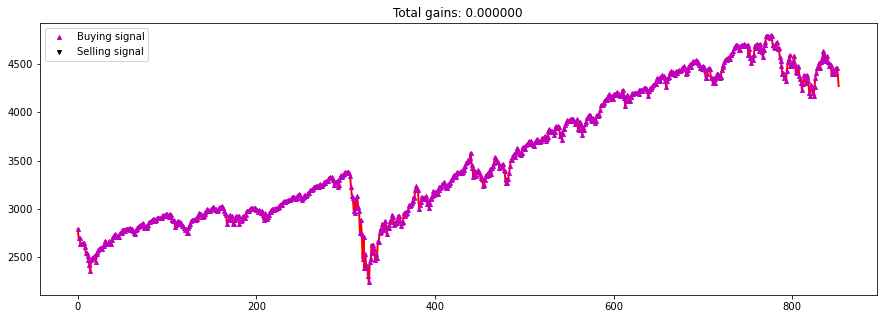

--------------------------------
Episode 9/100
--------------------------------
Profit: 4611.739990234375


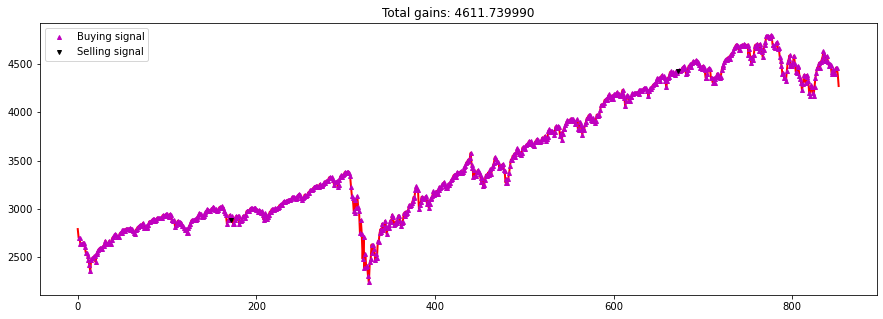

--------------------------------
Episode 10/100
--------------------------------
Profit: 0


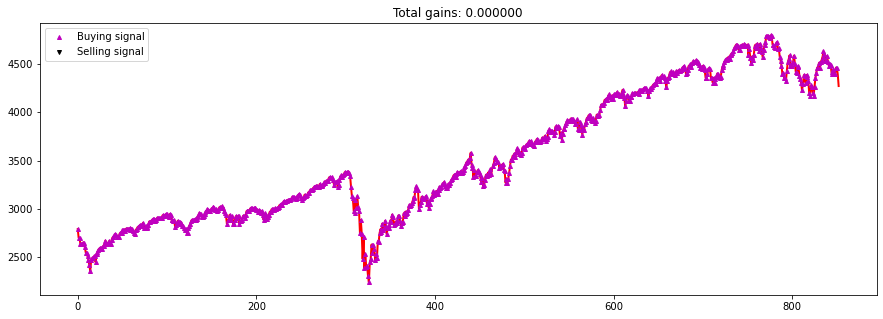

--------------------------------
Episode 11/100
--------------------------------
Profit: 0


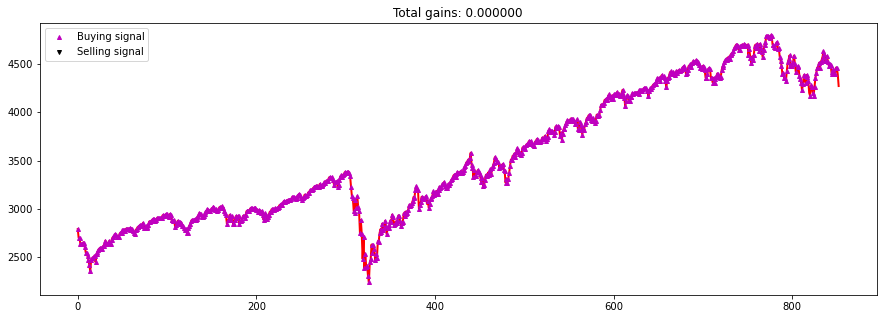

--------------------------------
Episode 12/100
--------------------------------
Profit: 4834.159912109375


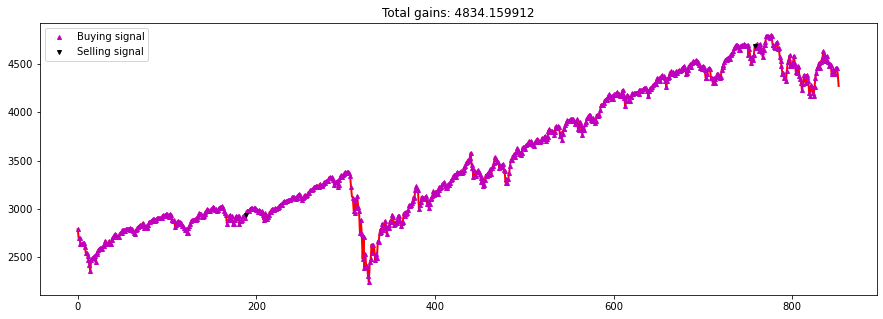

--------------------------------
Episode 13/100
--------------------------------
Profit: 0


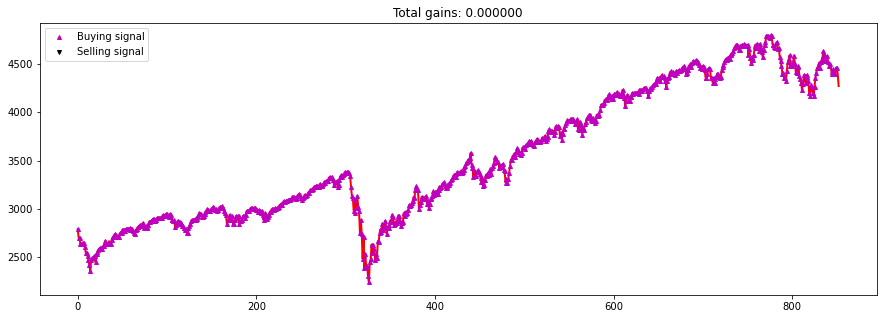

--------------------------------
Episode 14/100
--------------------------------
Profit: 4559.199951171875


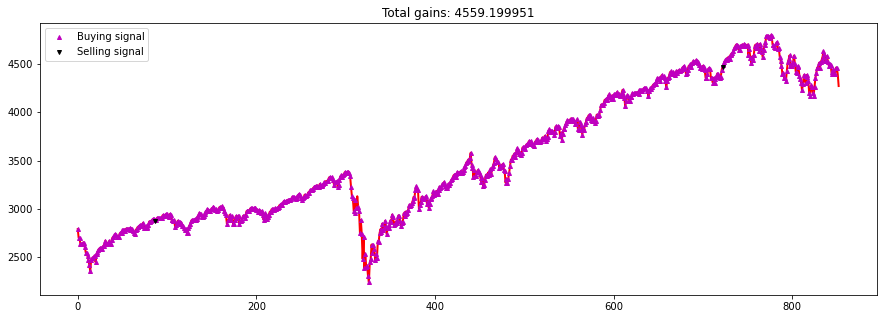

--------------------------------
Episode 15/100
--------------------------------
Profit: 5910.330078125


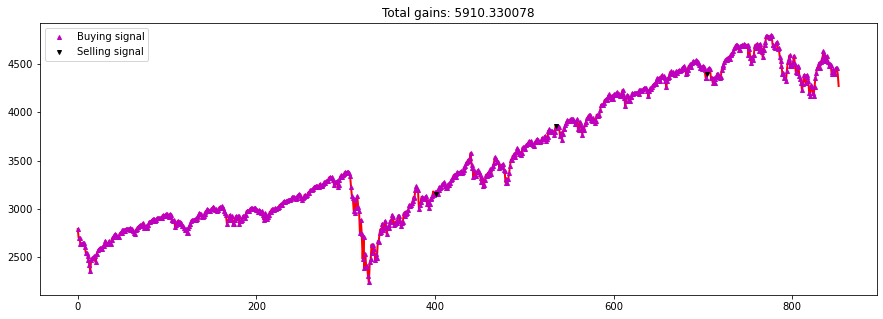

--------------------------------
Episode 16/100
--------------------------------
Profit: 3881.3701171875


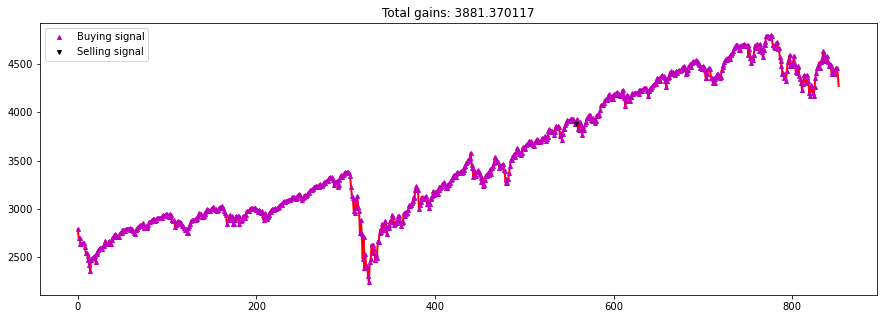

--------------------------------
Episode 17/100
--------------------------------
Profit: 6100.610107421875


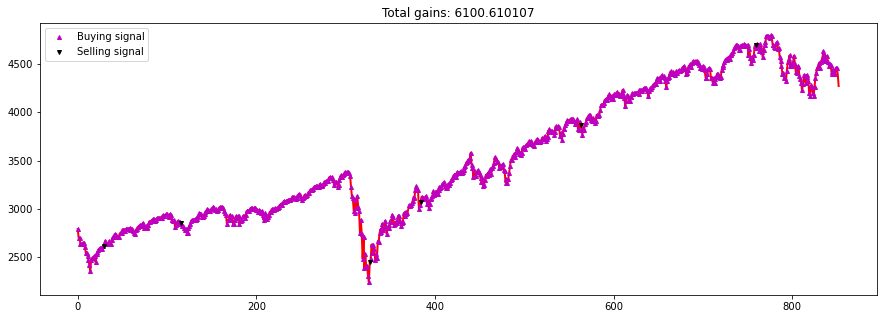

--------------------------------
Episode 18/100
--------------------------------
Profit: 3003.77978515625


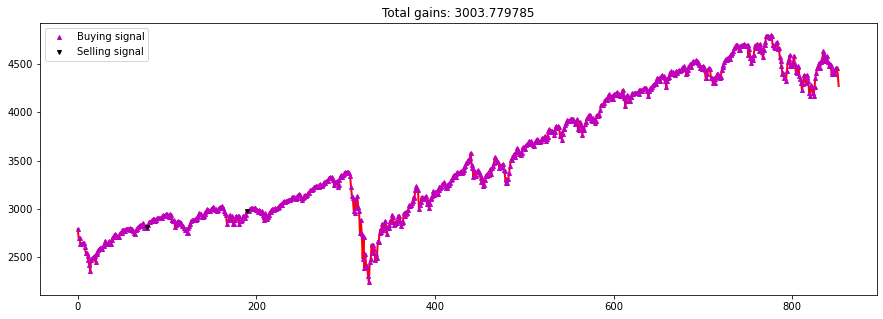

--------------------------------
Episode 19/100
--------------------------------
Profit: 3994.64990234375


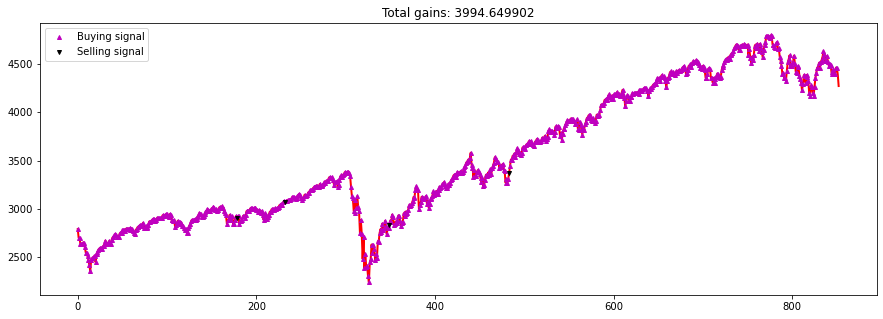

--------------------------------
Episode 20/100
--------------------------------
Profit: 4377.849853515625


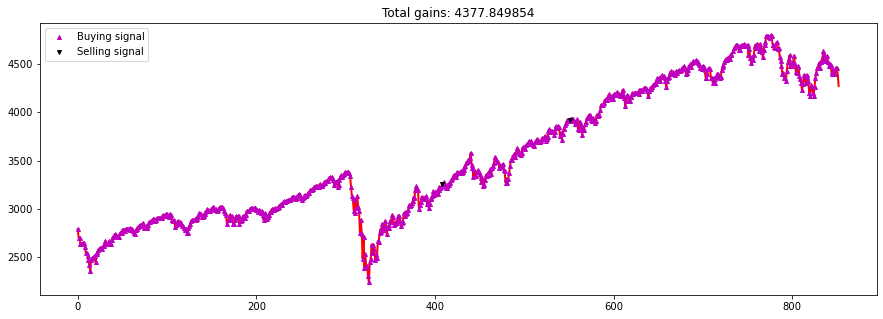

--------------------------------
Episode 21/100
--------------------------------
Profit: 6780.639892578125


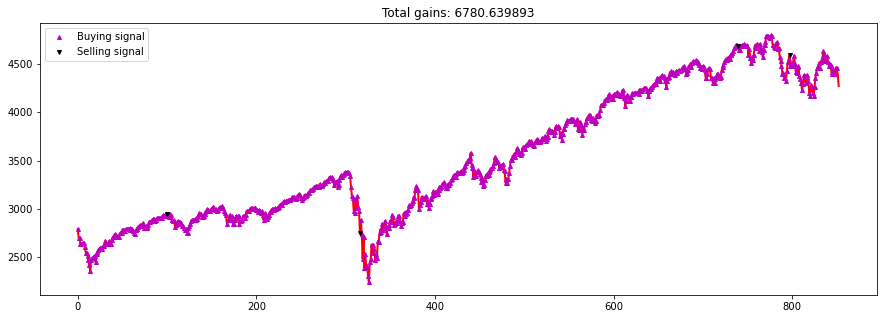

--------------------------------
Episode 22/100
--------------------------------
Profit: 0


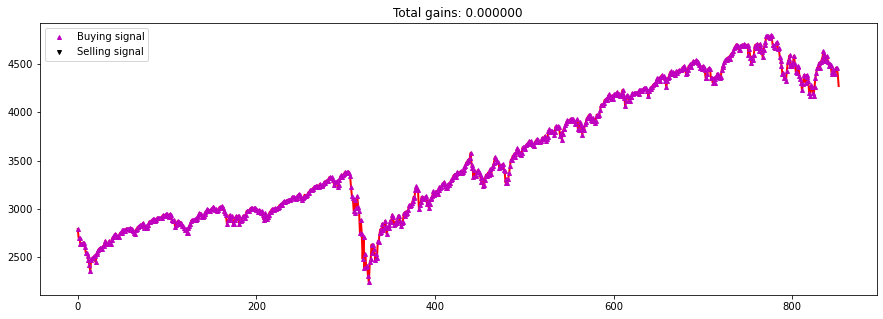

--------------------------------
Episode 23/100
--------------------------------
Profit: 3167.599853515625


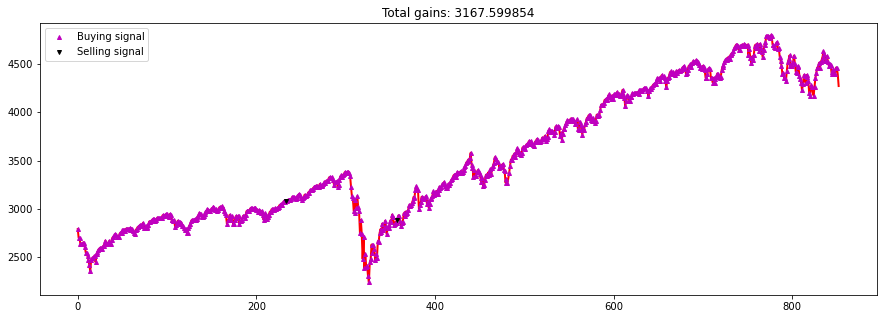

--------------------------------
Episode 24/100
--------------------------------
Profit: 4902.969970703125


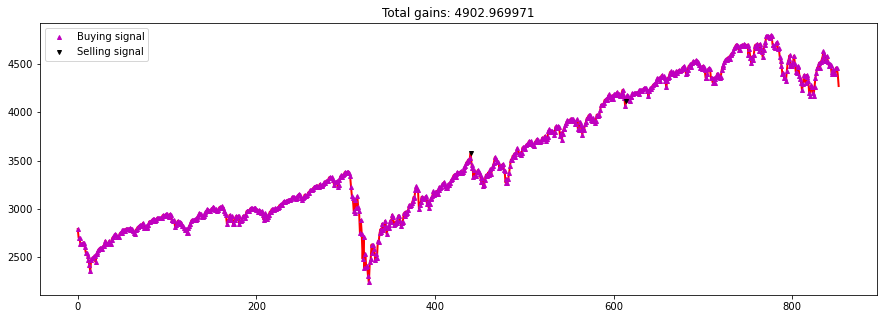

--------------------------------
Episode 25/100
--------------------------------
Profit: 3237.849853515625


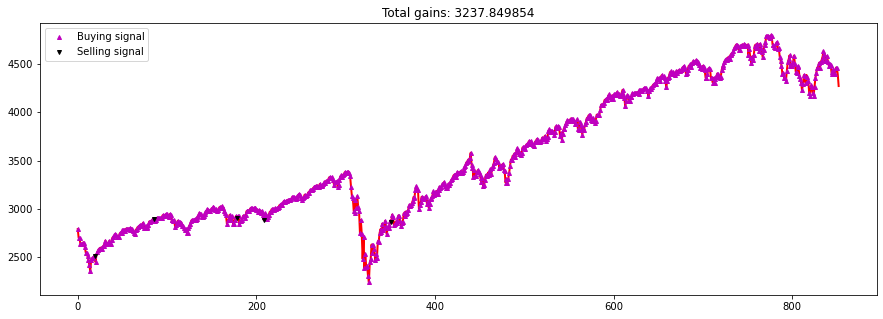

--------------------------------
Episode 26/100
--------------------------------
Profit: 5414.059814453125


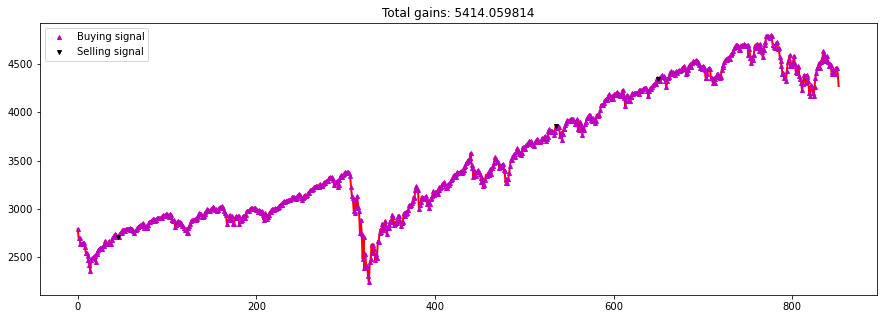

--------------------------------
Episode 27/100
--------------------------------
Profit: 11056.160400390625


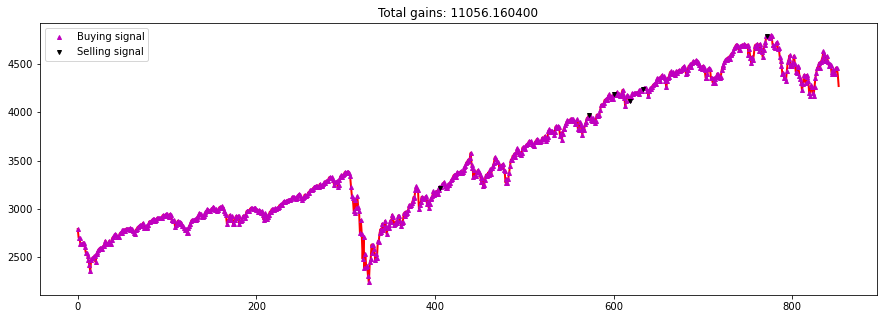

--------------------------------
Episode 28/100
--------------------------------
Profit: 5886.77978515625


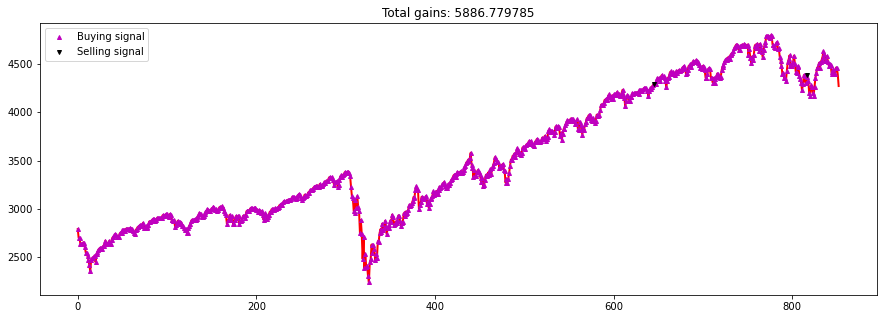

--------------------------------
Episode 29/100
--------------------------------
Profit: 3283.659912109375


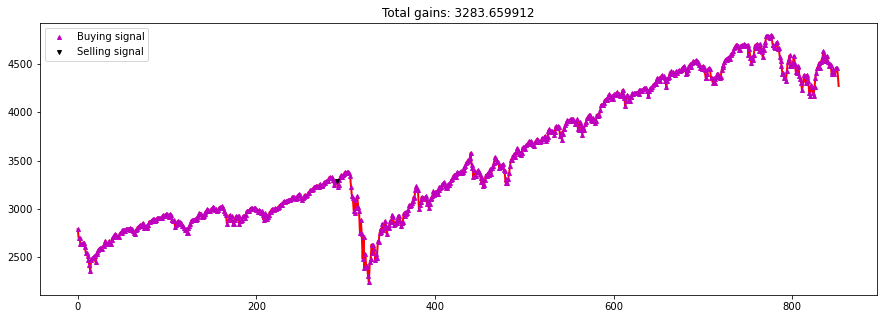

--------------------------------
Episode 30/100
--------------------------------
Profit: 5293.109619140625


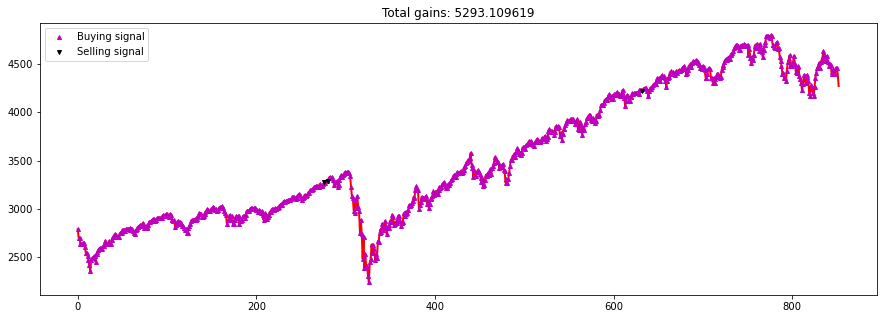

--------------------------------
Episode 31/100
--------------------------------
Profit: 2792.669921875


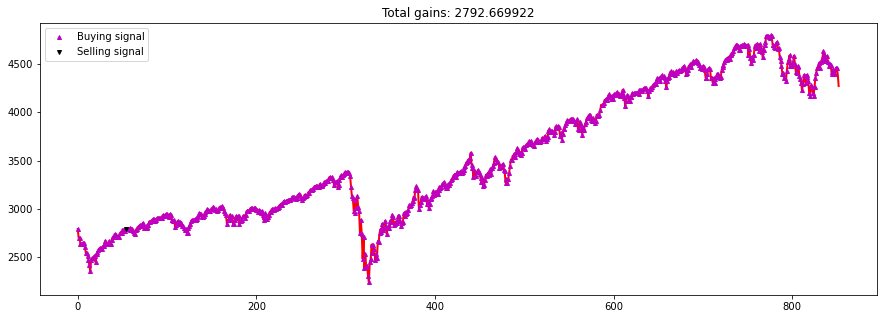

--------------------------------
Episode 32/100
--------------------------------
Profit: 3190.139892578125


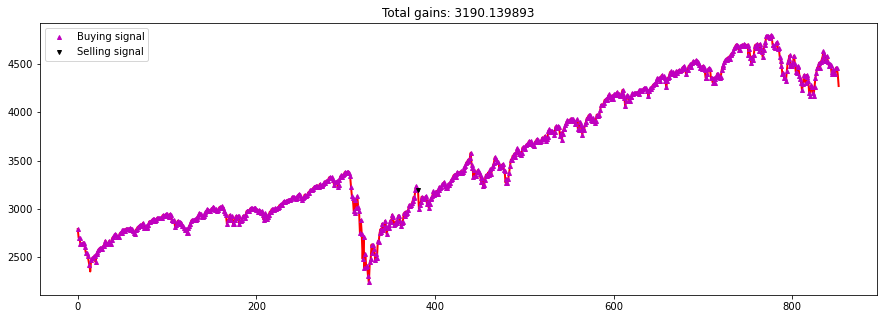

--------------------------------
Episode 33/100
--------------------------------
Profit: 4614.22998046875


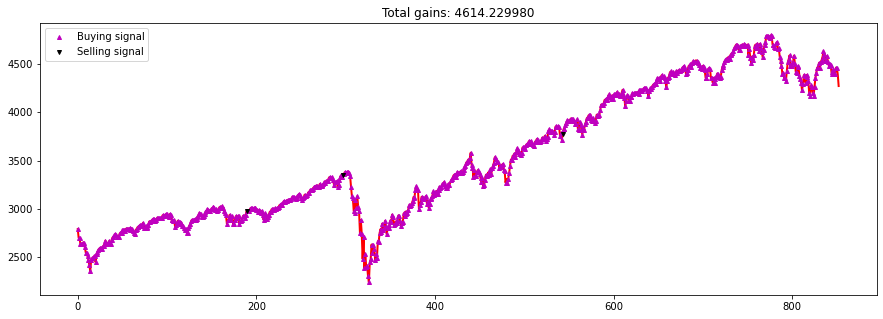

--------------------------------
Episode 34/100
--------------------------------
Profit: 5392.5


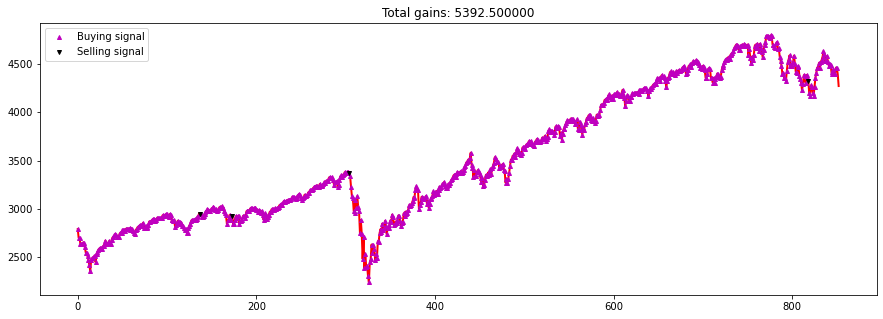

--------------------------------
Episode 35/100
--------------------------------
Profit: 7144.709716796875


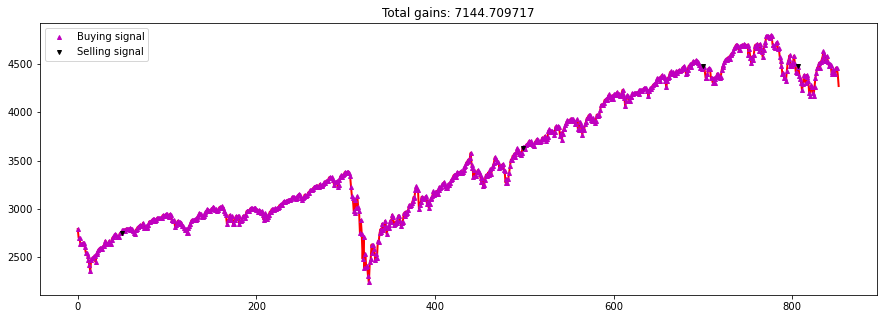

--------------------------------
Episode 36/100
--------------------------------
Profit: 7678.6396484375


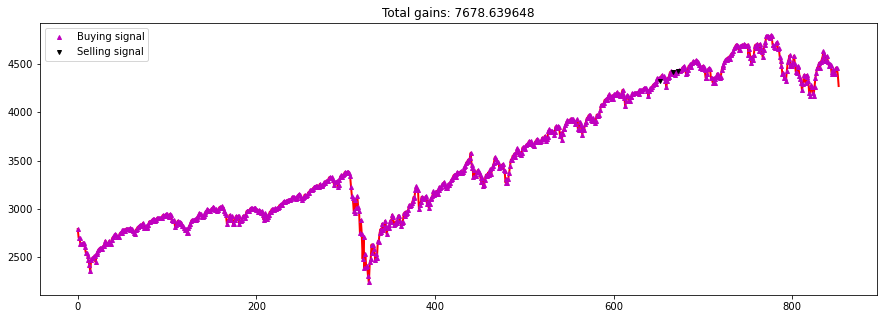

--------------------------------
Episode 37/100
--------------------------------
Profit: 5261.27001953125


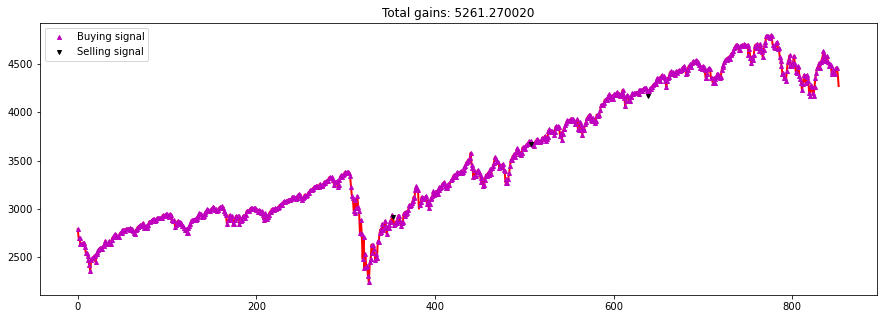

--------------------------------
Episode 38/100
--------------------------------
Profit: 6314.170166015625


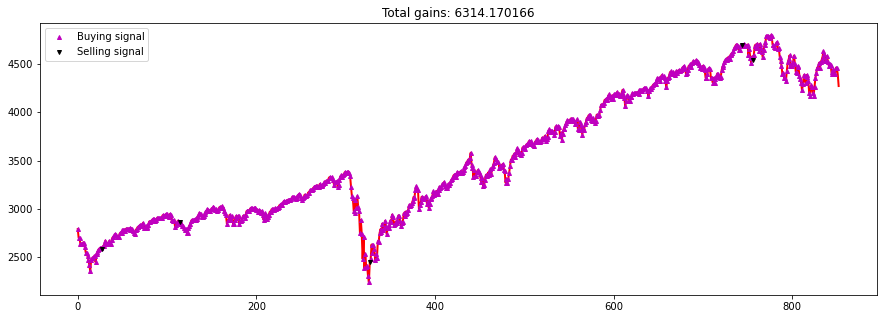

--------------------------------
Episode 39/100
--------------------------------
Profit: 3642.599609375


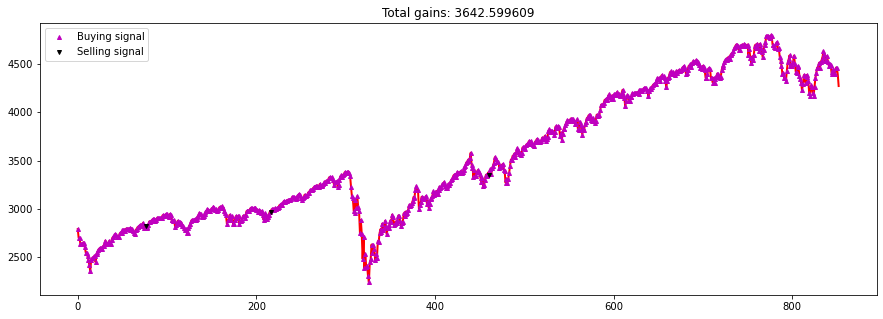

--------------------------------
Episode 40/100
--------------------------------
Profit: 2945.830078125


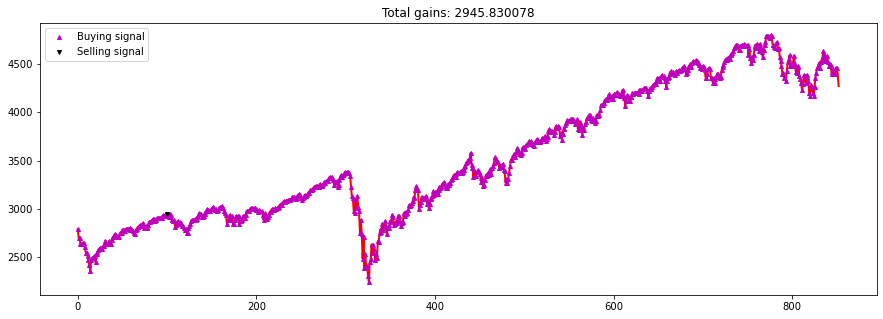

--------------------------------
Episode 41/100
--------------------------------
Profit: 2922.93994140625


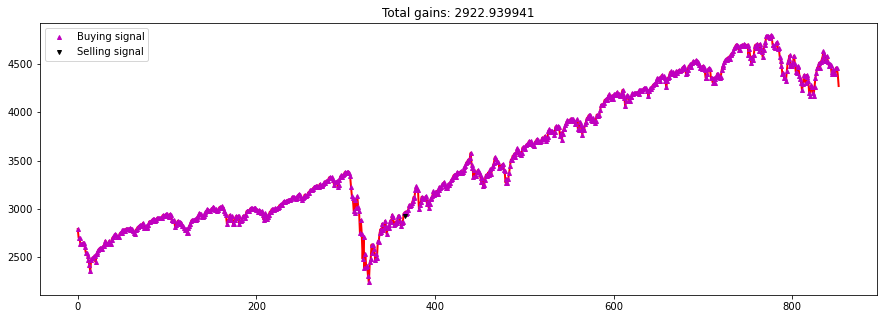

--------------------------------
Episode 42/100
--------------------------------
Profit: 3404.619873046875


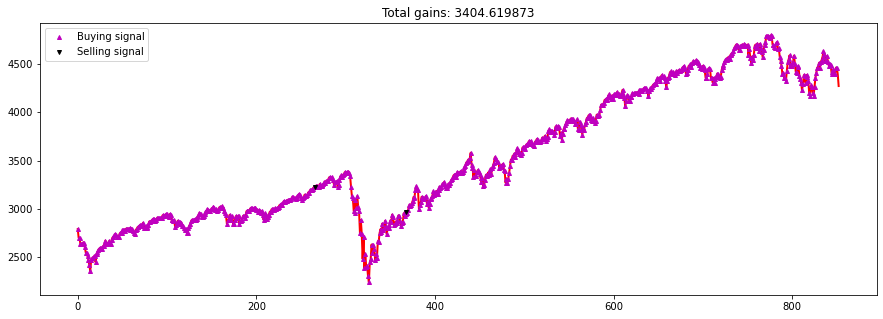

--------------------------------
Episode 43/100
--------------------------------
Profit: 4577.10986328125


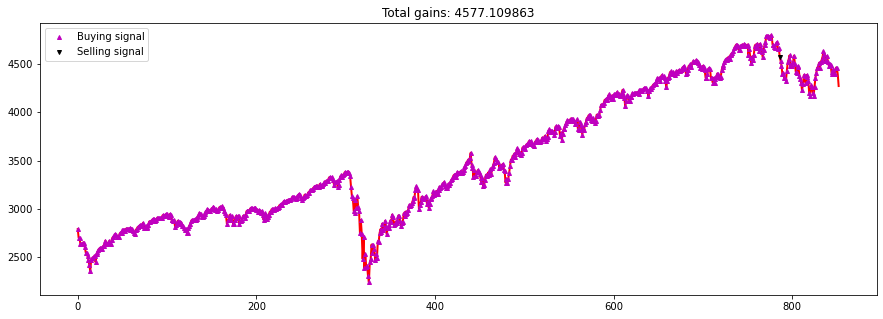

--------------------------------
Episode 44/100
--------------------------------
Profit: 4163.2900390625


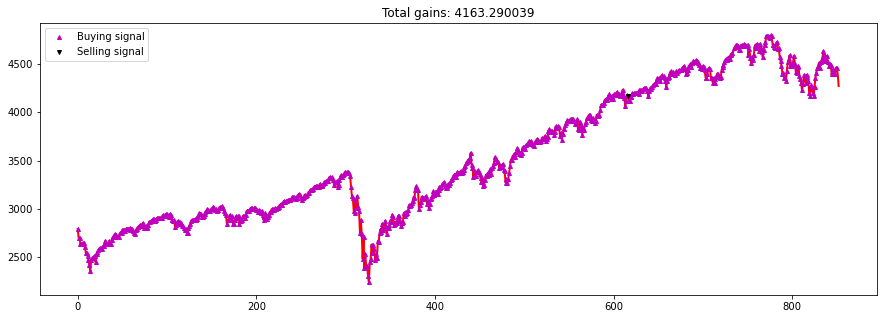

--------------------------------
Episode 45/100
--------------------------------
Profit: 4246.43994140625


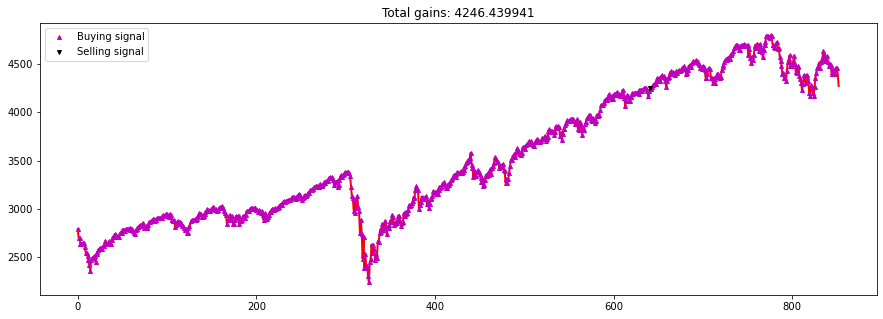

--------------------------------
Episode 46/100
--------------------------------
Profit: 9655.649658203125


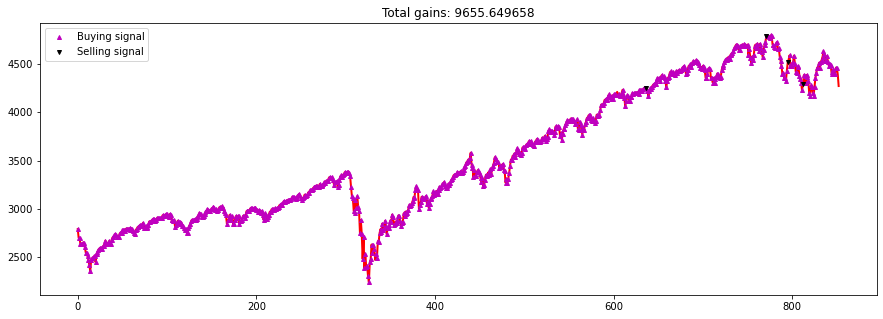

--------------------------------
Episode 47/100
--------------------------------
Profit: 3666.719970703125


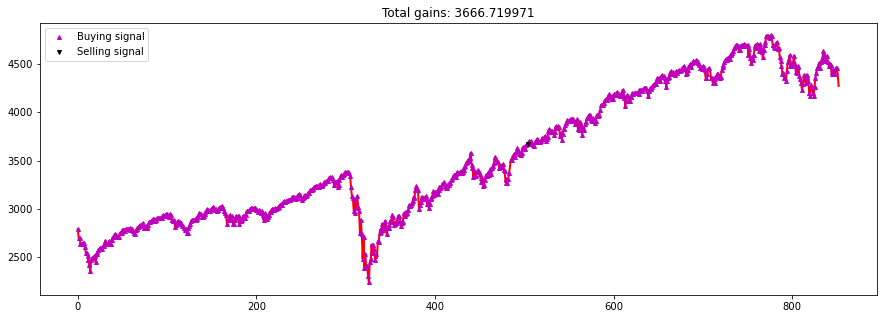

--------------------------------
Episode 48/100
--------------------------------
Profit: 3225.889892578125


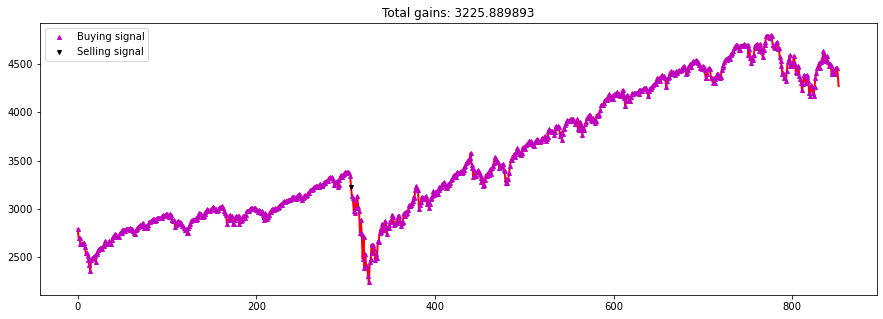

--------------------------------
Episode 49/100
--------------------------------
Profit: 2995.110107421875


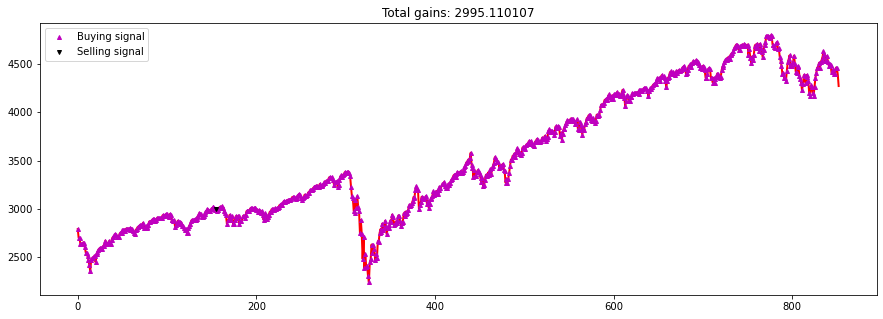

--------------------------------
Episode 50/100
--------------------------------
Profit: 7090.229736328125


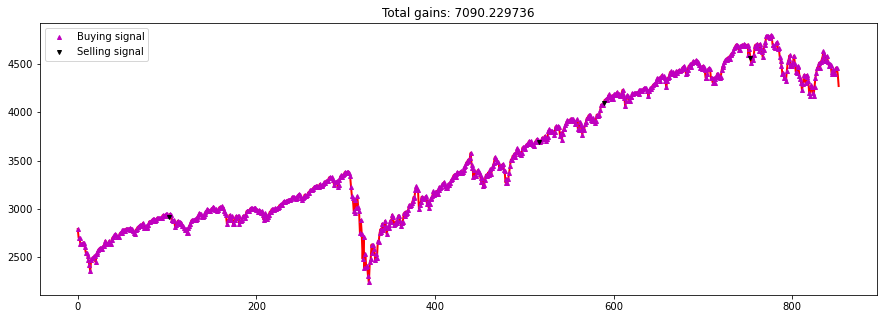

--------------------------------
Episode 51/100
--------------------------------
Profit: 6577.4697265625


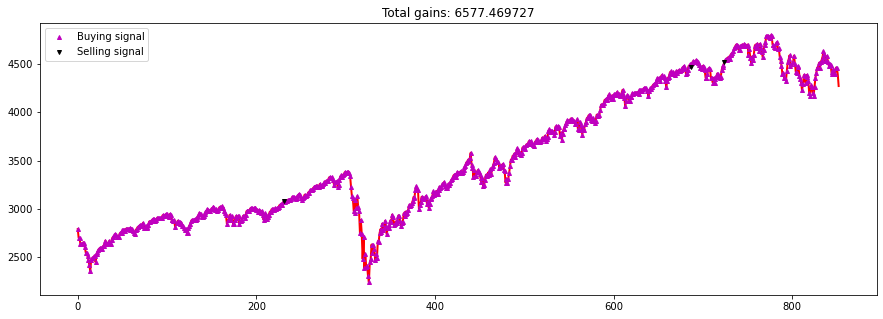

--------------------------------
Episode 52/100
--------------------------------
Profit: 7271.8798828125


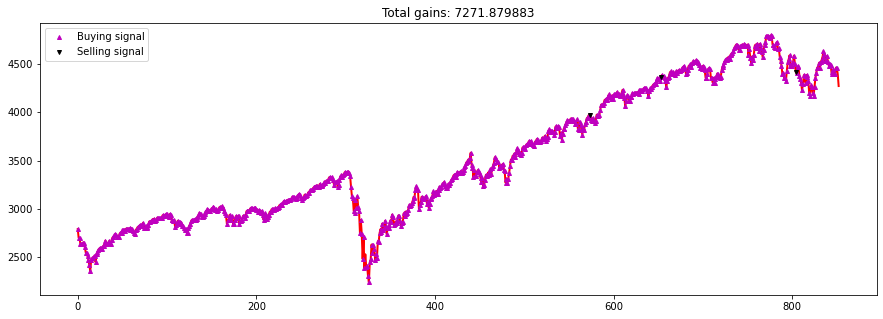

--------------------------------
Episode 53/100
--------------------------------
Profit: 4744.41943359375


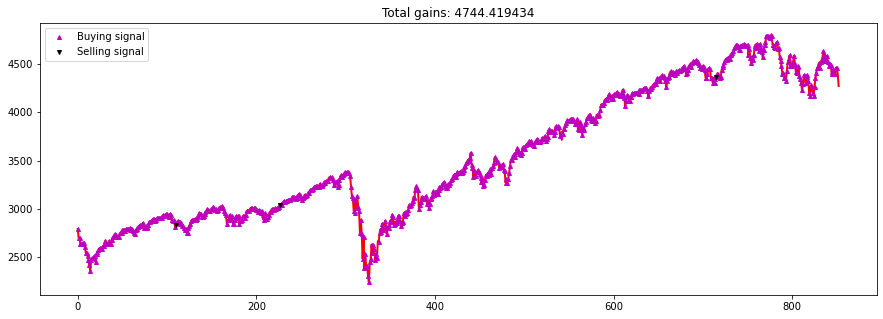

--------------------------------
Episode 54/100
--------------------------------
Profit: 3078.27001953125


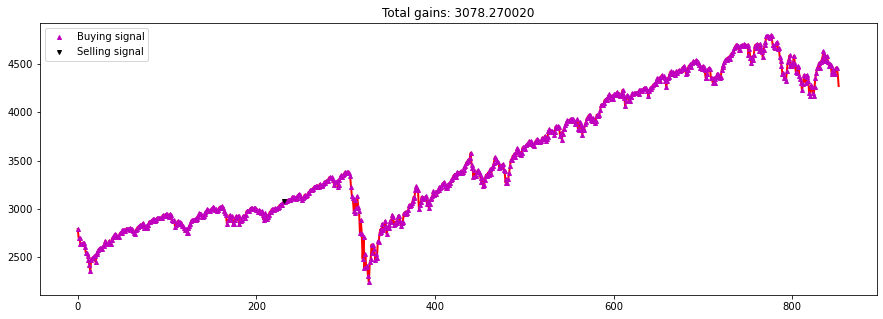

--------------------------------
Episode 55/100
--------------------------------
Profit: 6431.7197265625


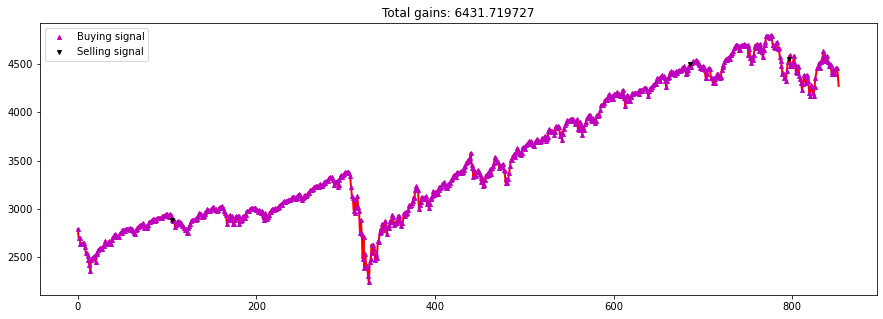

--------------------------------
Episode 56/100
--------------------------------
Profit: 4377.229736328125


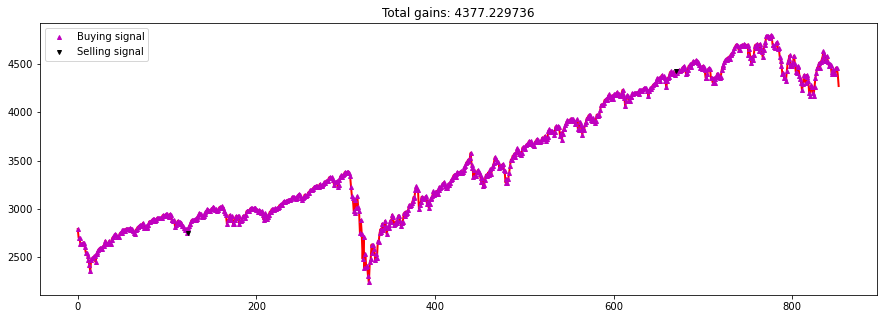

--------------------------------
Episode 57/100
--------------------------------
Profit: 4072.7197265625


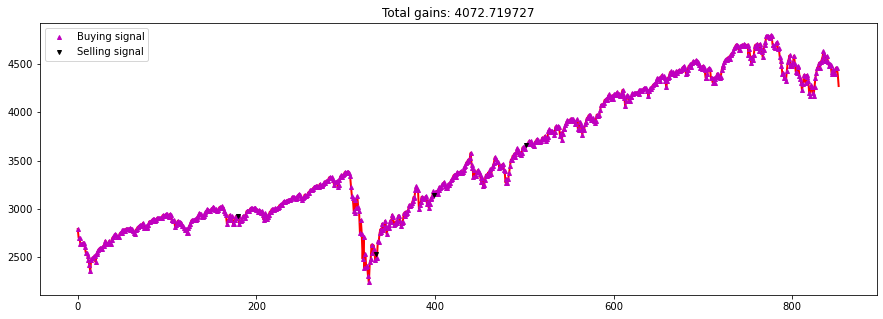

--------------------------------
Episode 58/100
--------------------------------
Profit: 2434.570068359375


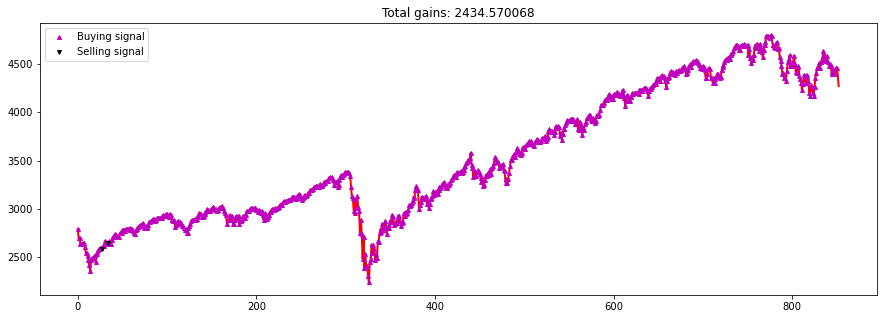

--------------------------------
Episode 59/100
--------------------------------
Profit: 9241.569580078125


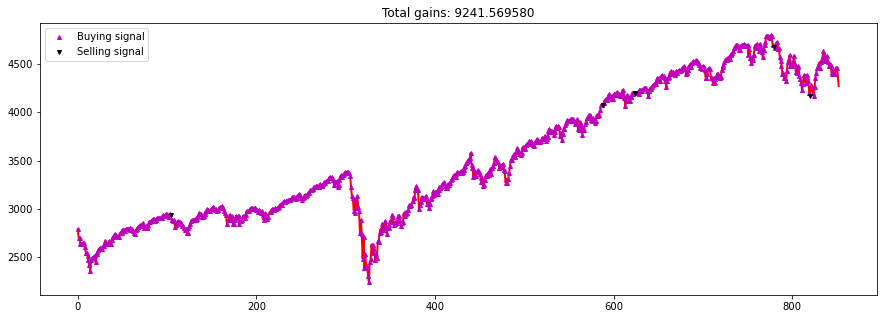

--------------------------------
Episode 60/100
--------------------------------
Profit: 4784.659912109375


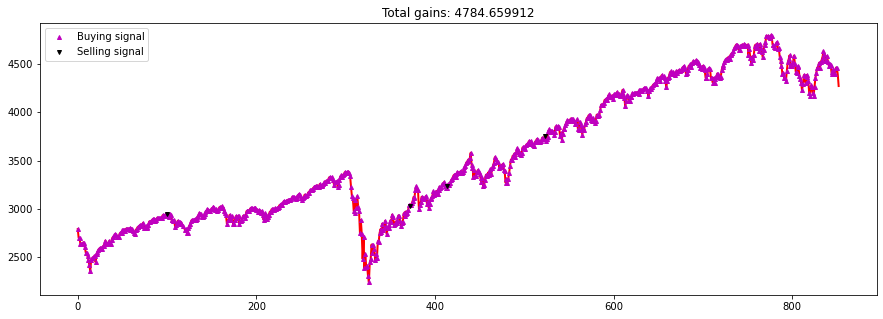

--------------------------------
Episode 61/100
--------------------------------
Profit: 3045.39990234375


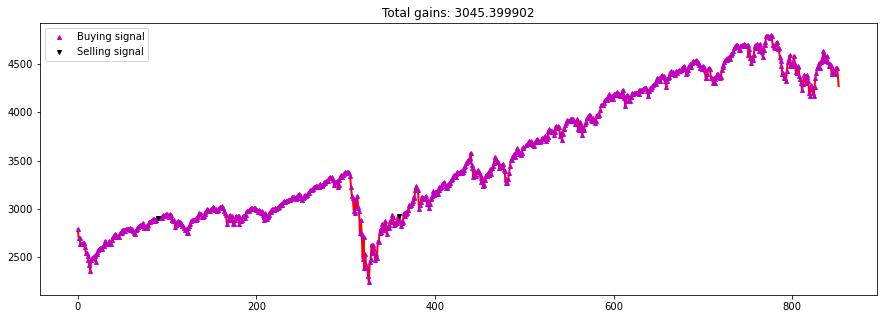

--------------------------------
Episode 62/100
--------------------------------
Profit: 4137.4296875


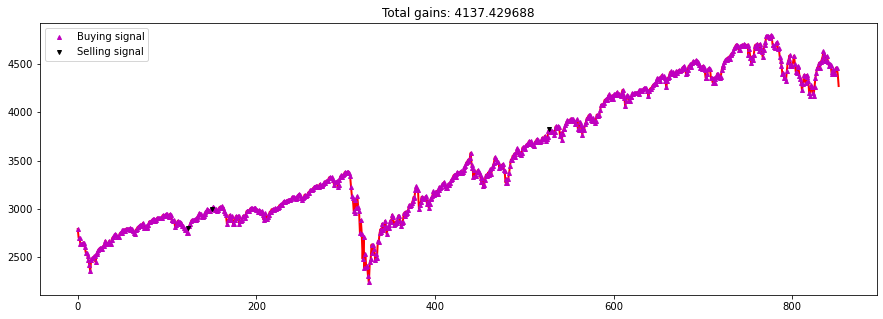

--------------------------------
Episode 63/100
--------------------------------
Profit: 3113.489990234375


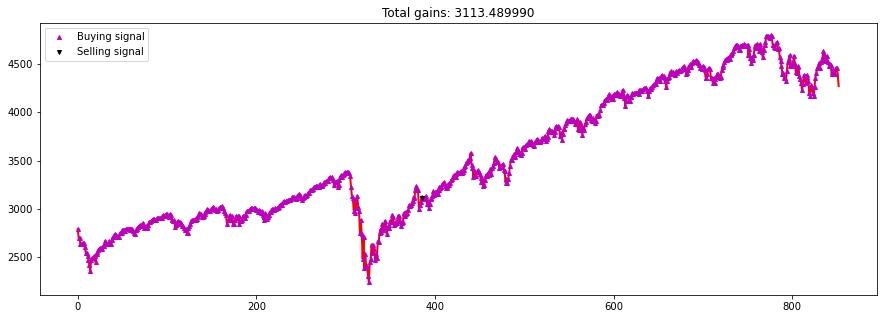

--------------------------------
Episode 64/100
--------------------------------
Profit: 5273.72998046875


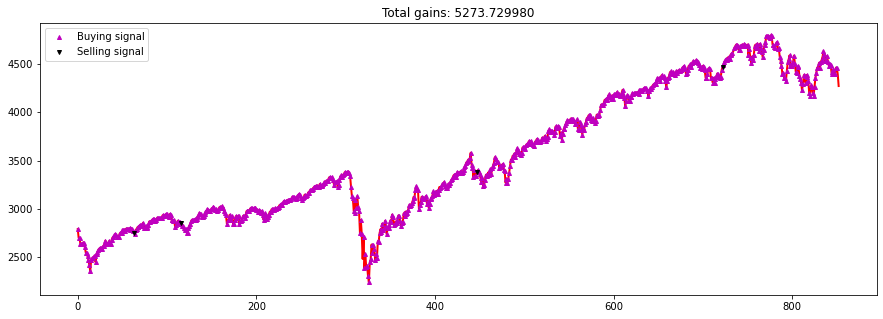

--------------------------------
Episode 65/100
--------------------------------
Profit: 4455.739501953125


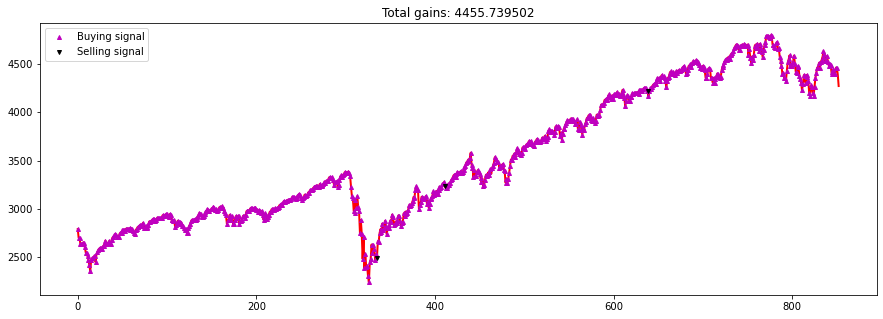

--------------------------------
Episode 66/100
--------------------------------
Profit: 3506.889892578125


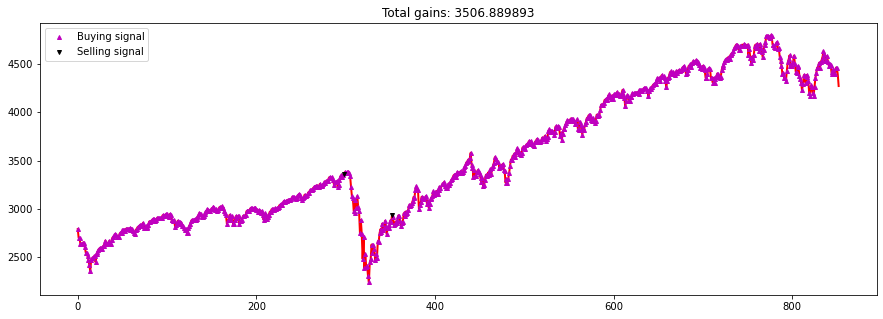

--------------------------------
Episode 67/100
--------------------------------
Profit: 5407.19970703125


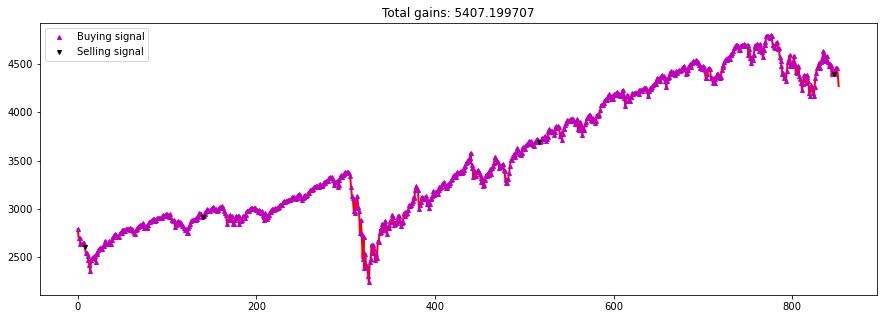

--------------------------------
Episode 68/100
--------------------------------
Profit: 4893.549560546875


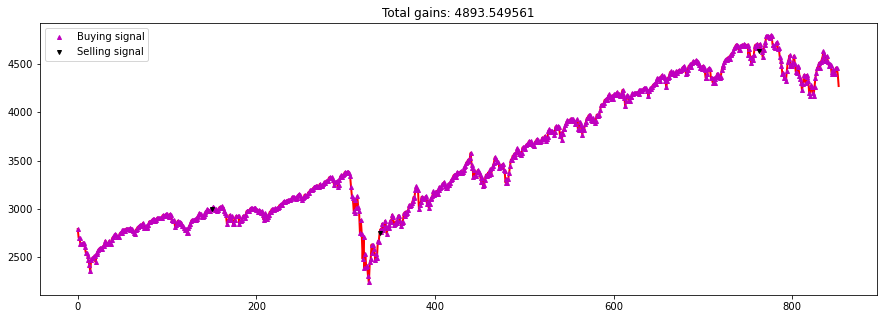

--------------------------------
Episode 69/100
--------------------------------
Profit: 5484.759765625


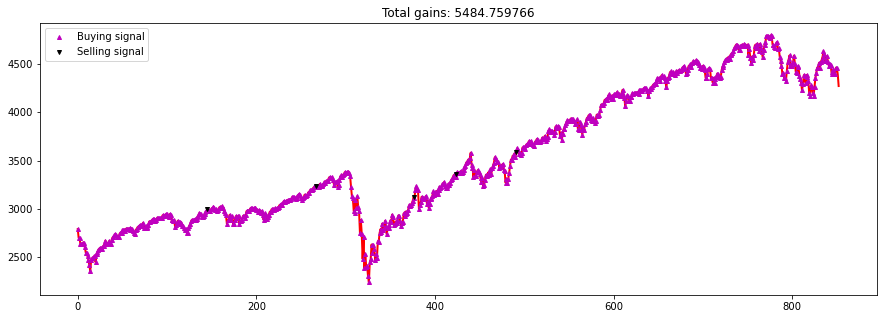

--------------------------------
Episode 70/100
--------------------------------
Profit: 2945.169921875


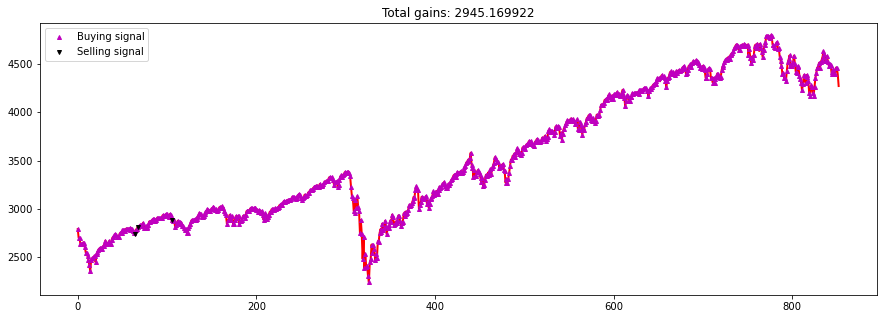

--------------------------------
Episode 71/100
--------------------------------
Profit: 7103.8896484375


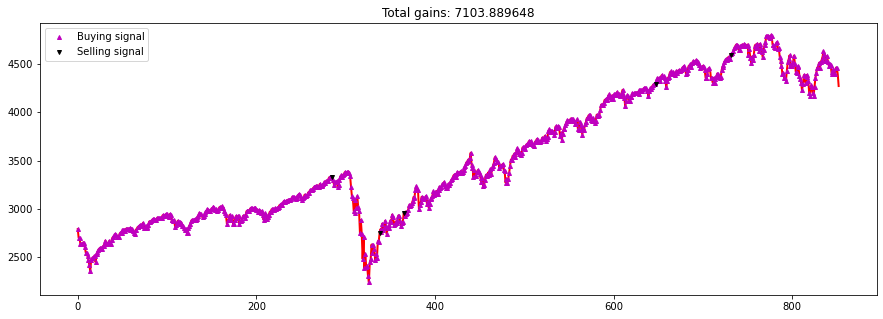

--------------------------------
Episode 72/100
--------------------------------
Profit: 0


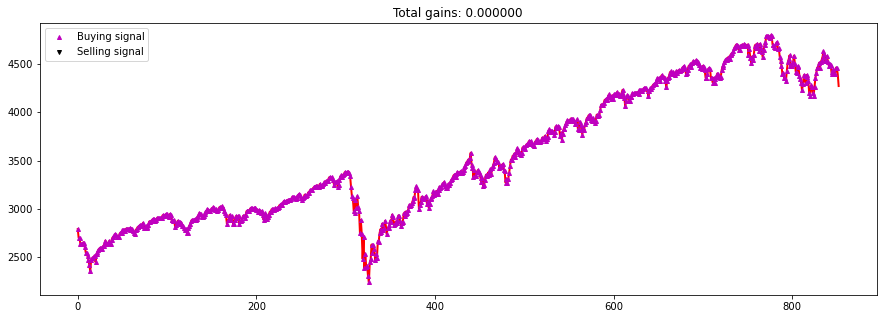

--------------------------------
Episode 73/100
--------------------------------
Profit: 4948.769775390625


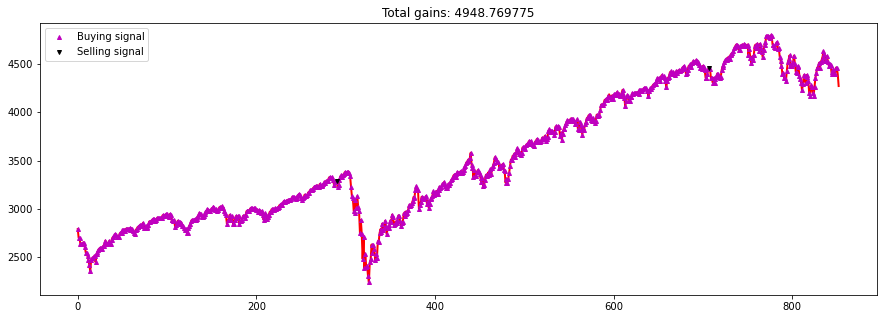

--------------------------------
Episode 74/100
--------------------------------
Profit: 3387.509765625


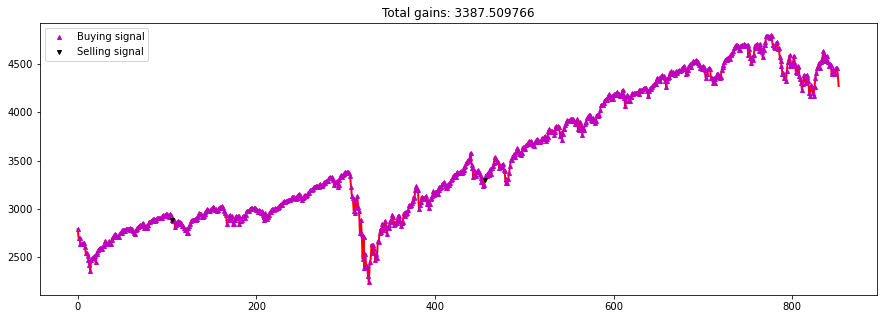

--------------------------------
Episode 75/100
--------------------------------
Profit: 0


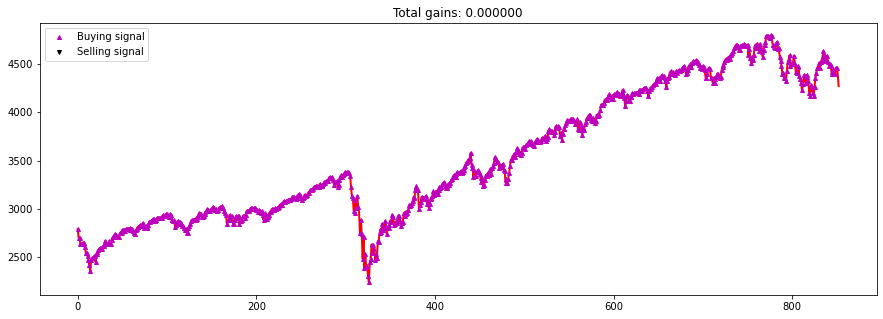

--------------------------------
Episode 76/100
--------------------------------
Profit: 5853.179931640625


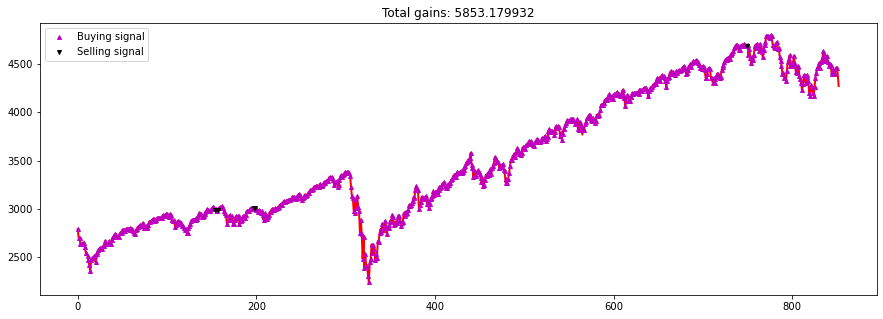

--------------------------------
Episode 77/100
--------------------------------
Profit: 0


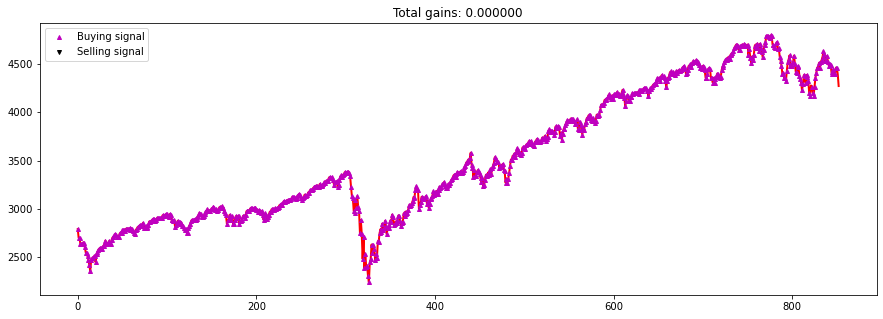

--------------------------------
Episode 78/100
--------------------------------
Profit: 4906.629638671875


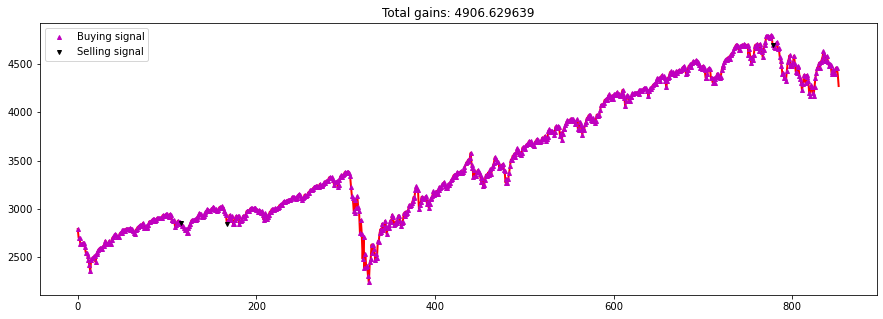

--------------------------------
Episode 79/100
--------------------------------
Profit: 4374.699951171875


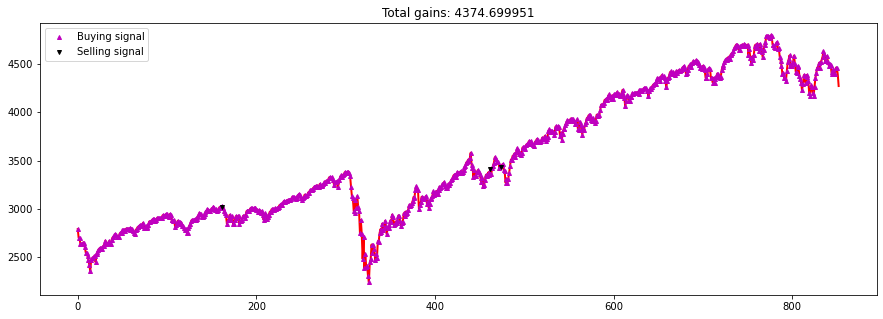

--------------------------------
Episode 80/100
--------------------------------
Profit: 5850.269775390625


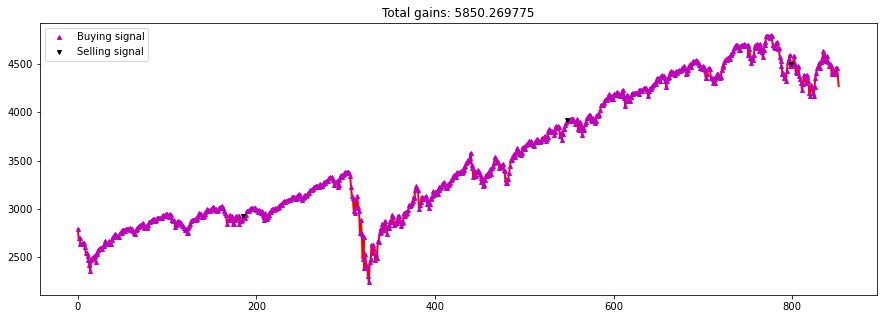

--------------------------------
Episode 81/100
--------------------------------
Profit: 7119.760009765625


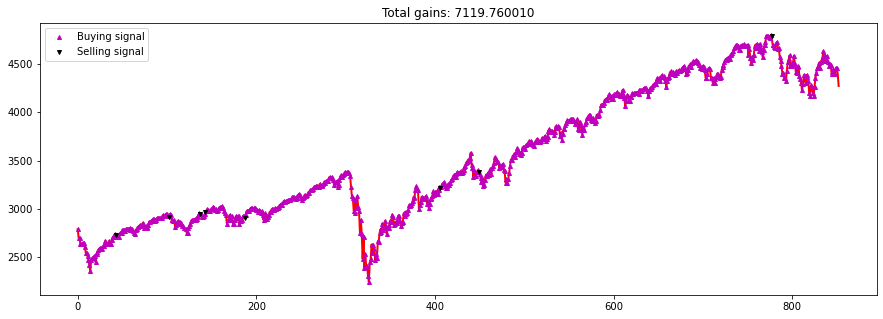

--------------------------------
Episode 82/100
--------------------------------
Profit: 3416.139892578125


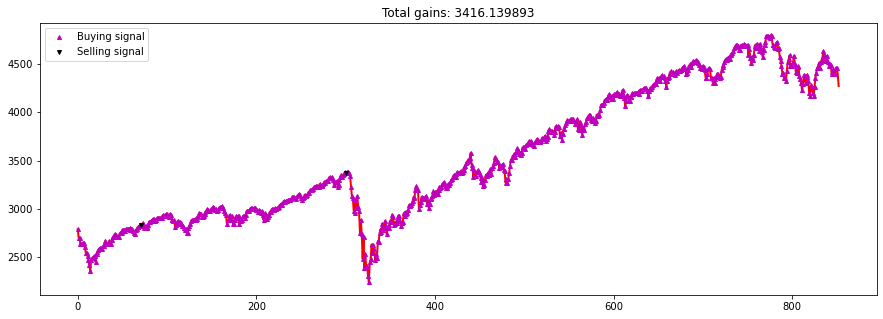

--------------------------------
Episode 83/100
--------------------------------
Profit: 7336.259765625


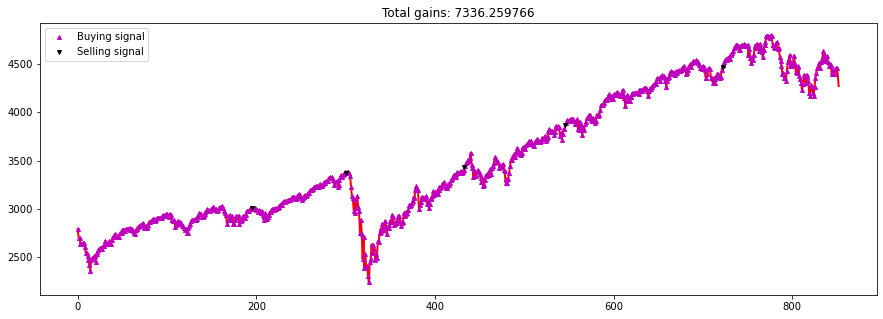

--------------------------------
Episode 84/100
--------------------------------
Profit: 2546.159912109375


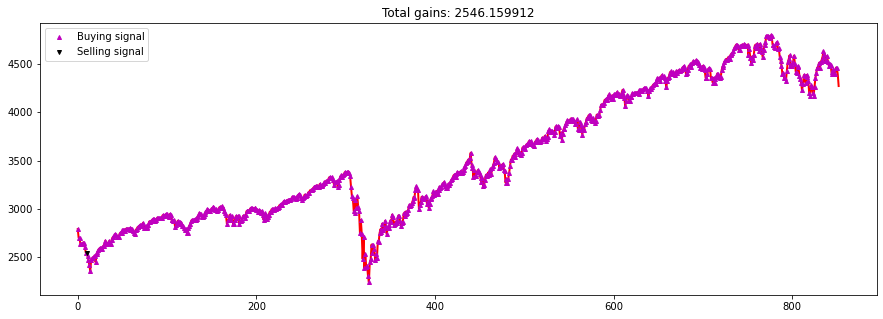

--------------------------------
Episode 85/100
--------------------------------
Profit: 4590.719970703125


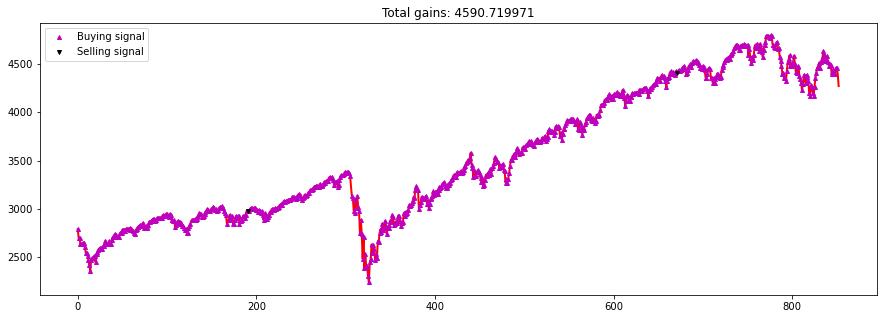

--------------------------------
Episode 86/100
--------------------------------
Profit: 3380.159912109375


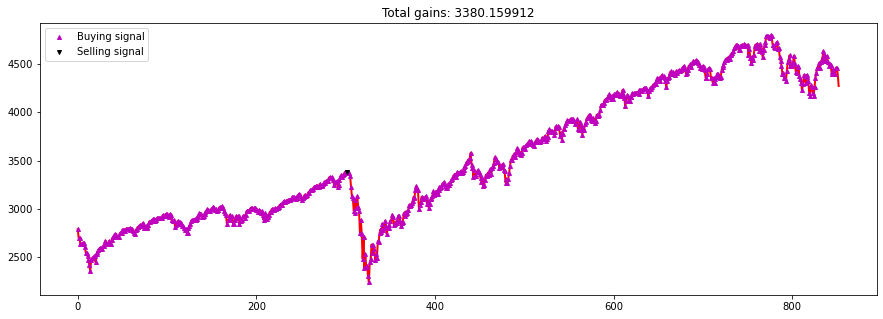

--------------------------------
Episode 87/100
--------------------------------
Profit: 6794.919677734375


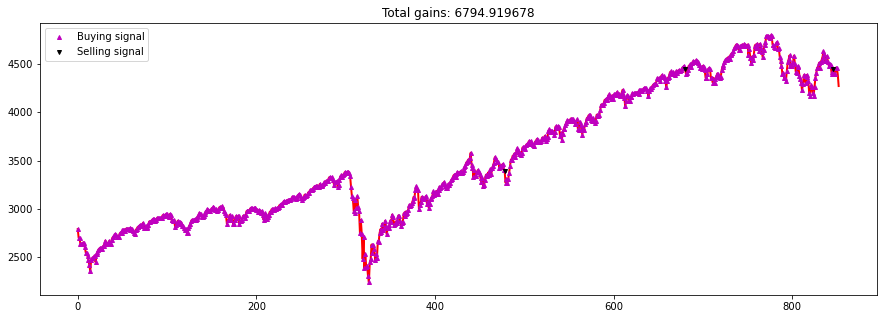

--------------------------------
Episode 88/100
--------------------------------
Profit: 3798.5400390625


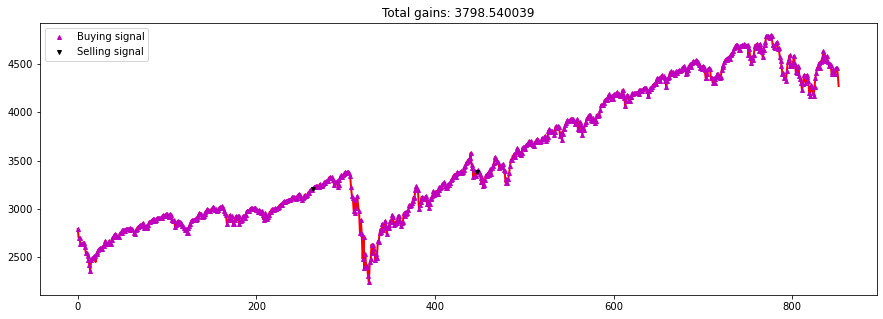

--------------------------------
Episode 89/100
--------------------------------
Profit: 2971.409912109375


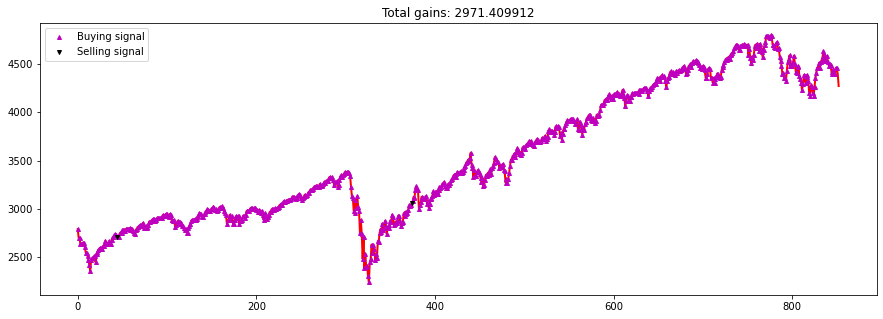

--------------------------------
Episode 90/100
--------------------------------
Profit: 4127.990234375


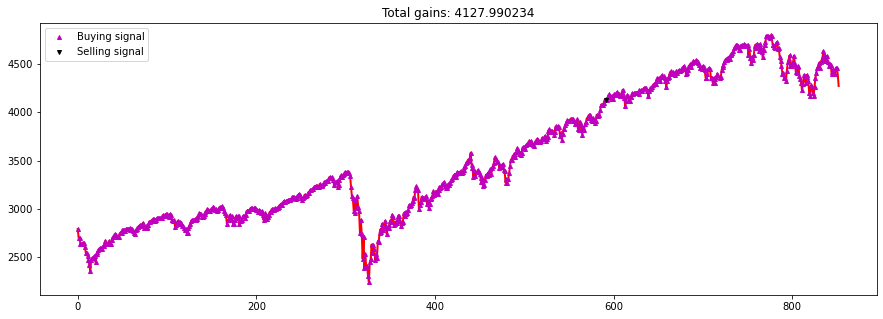

--------------------------------
Episode 91/100
--------------------------------
Profit: 2592.599853515625


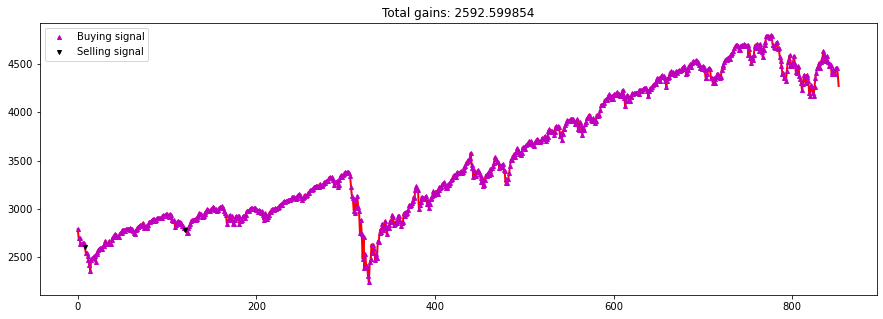

--------------------------------
Episode 92/100
--------------------------------
Profit: 6486.4599609375


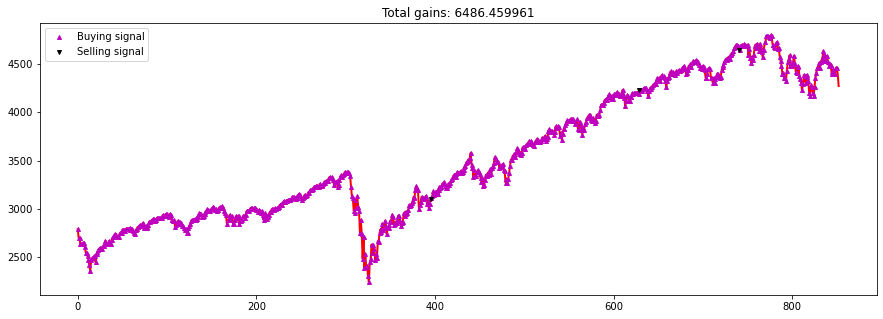

--------------------------------
Episode 93/100
--------------------------------
Profit: 6329.509765625


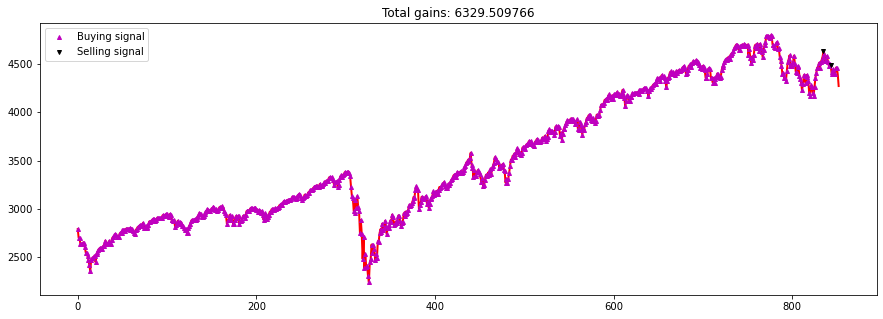

--------------------------------
Episode 94/100
--------------------------------
Profit: 6185.02001953125


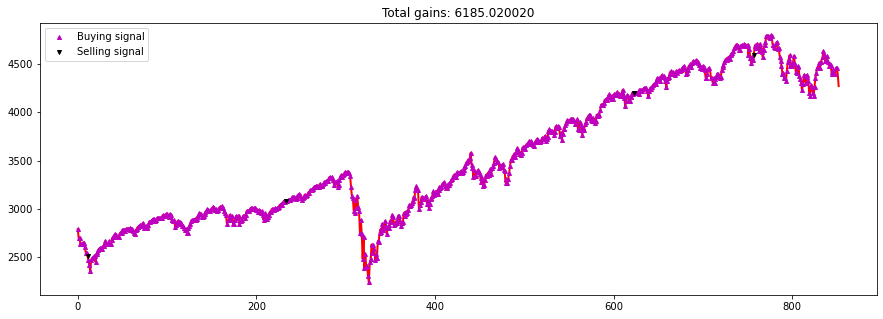

--------------------------------
Episode 95/100
--------------------------------
Profit: 5383.269775390625


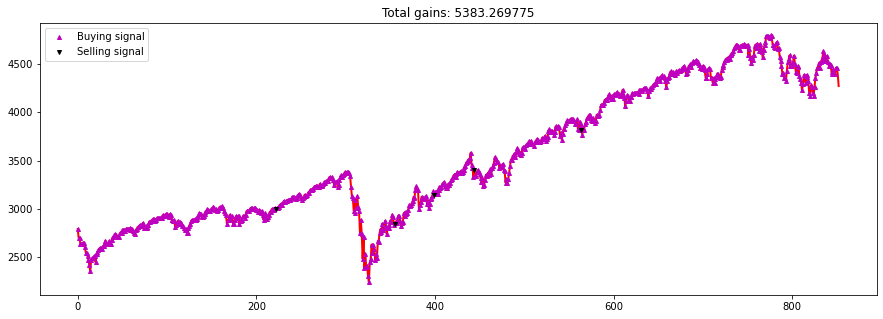

--------------------------------
Episode 96/100
--------------------------------
Profit: 7477.729736328125


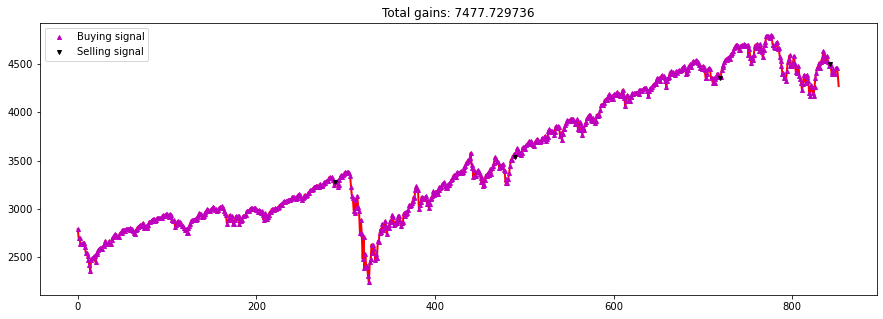

--------------------------------
Episode 97/100
--------------------------------
Profit: 6337.279541015625


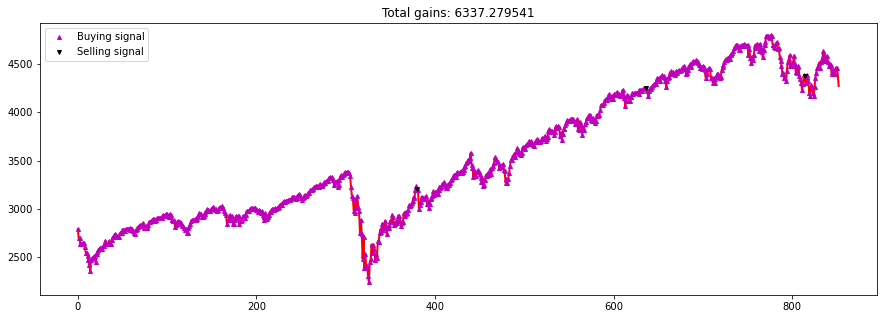

--------------------------------
Episode 98/100
--------------------------------
Profit: 8093.33984375


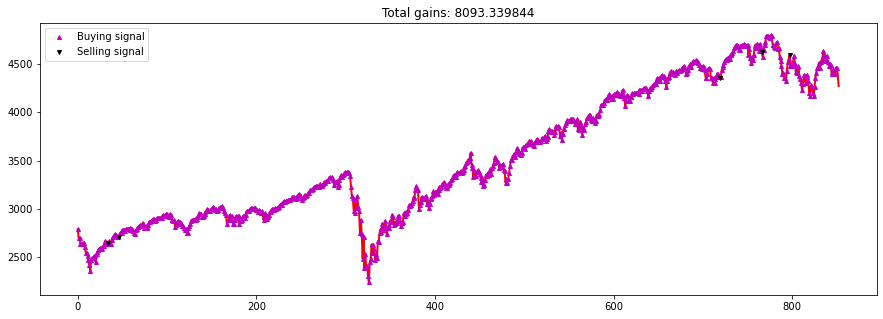

--------------------------------
Episode 99/100
--------------------------------
Profit: 3122.8701171875


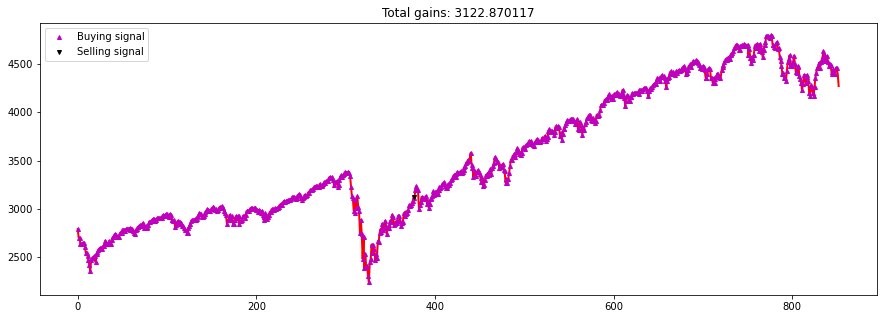

--------------------------------
Episode 100/100
--------------------------------
Profit: 3037.56005859375


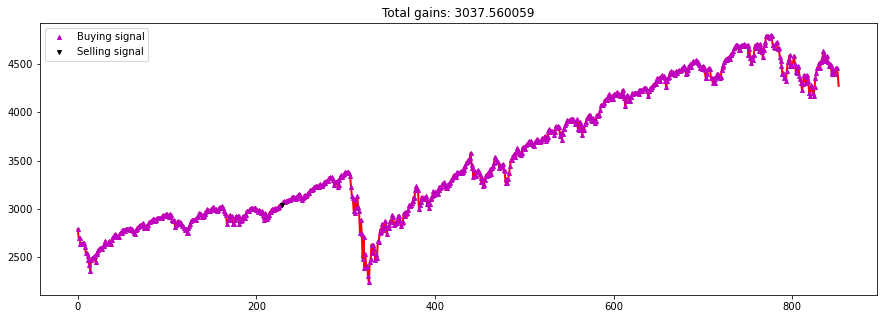

--------------------------------


In [33]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("^GSPC", start="2018-12-01").reset_index()
df_full.to_csv('GSPC.csv',index=False)
#df = df_full.sort_values('Date')
df= df_full.copy()
#df = np.around(df)
df = df['Close'].values.tolist()
#print(df)
episode = 100
env = StockTradingEnv(df,10) # the window size or  the state size is passed in it.
agent = QNAgent(env)
train_data = df
l = len(train_data) - 1 
batch_size=32

for i in range(episode+1):
    print ("Episode " + str(i) + "/" + str(episode))
    state = env.reset(0)
    total_profit = 0 
    agent.inventory = [0]
    for i in range(l):
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action,i+1) 
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            print ("--------------------------------")
            env.render() # outputs the graph and the total profit.
            print ("--------------------------------")
        
        batch_size = min(batch_size, len(agent.memory)) # batch size is used to make the model learn faster by the factor of the batch_size
        agent.train(batch_size)
        
      

          

